## Machine Learning Assignment 2

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import warnings
import zipfile
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

data = pd.read_csv('data_labels_mainData.csv')

### Exploratory Data Analysis

Lets see the data we are working with

In [2]:
data.shape

(9896, 6)

In [3]:
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [4]:
data['isCancerous'].unique()

array([0, 1])

Observations:
- the target variable is binary encoded

Lets see if the classification of the target variable is balanced:

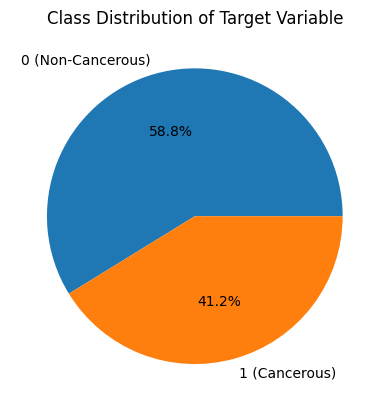

0 (Non-Cancerous): 5817
1 (Cancerous): 4079


In [5]:
import matplotlib.pyplot as plt

plt.title('Class Distribution of Target Variable')

class_count = data['isCancerous'].value_counts()

# number of samples in each class
class_counts = [class_count[0], class_count[1]]

# create the pie chart
plt.pie(class_counts, labels=['0 (Non-Cancerous)', '1 (Cancerous)'], autopct='%1.1f%%')
plt.show()
print("0 (Non-Cancerous):", class_count[0])
print("1 (Cancerous):", class_count[1])

Observations:
- the classes are slightly imbalanced
- the 0 (Non-Cancerous) class has approximately 1700 more samples which makes up 8.8% of the data

Lets see if we have any null values in the data:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


Observations:
- there are no null values in the data
- the datatypes in the ImageName, and cellTypeName columns are object but it is better to have them as string

Lets examine the statistical analysis of the data:

In [7]:
data.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


Lets look at a few randomly selected images in each class to see the variation in the images:

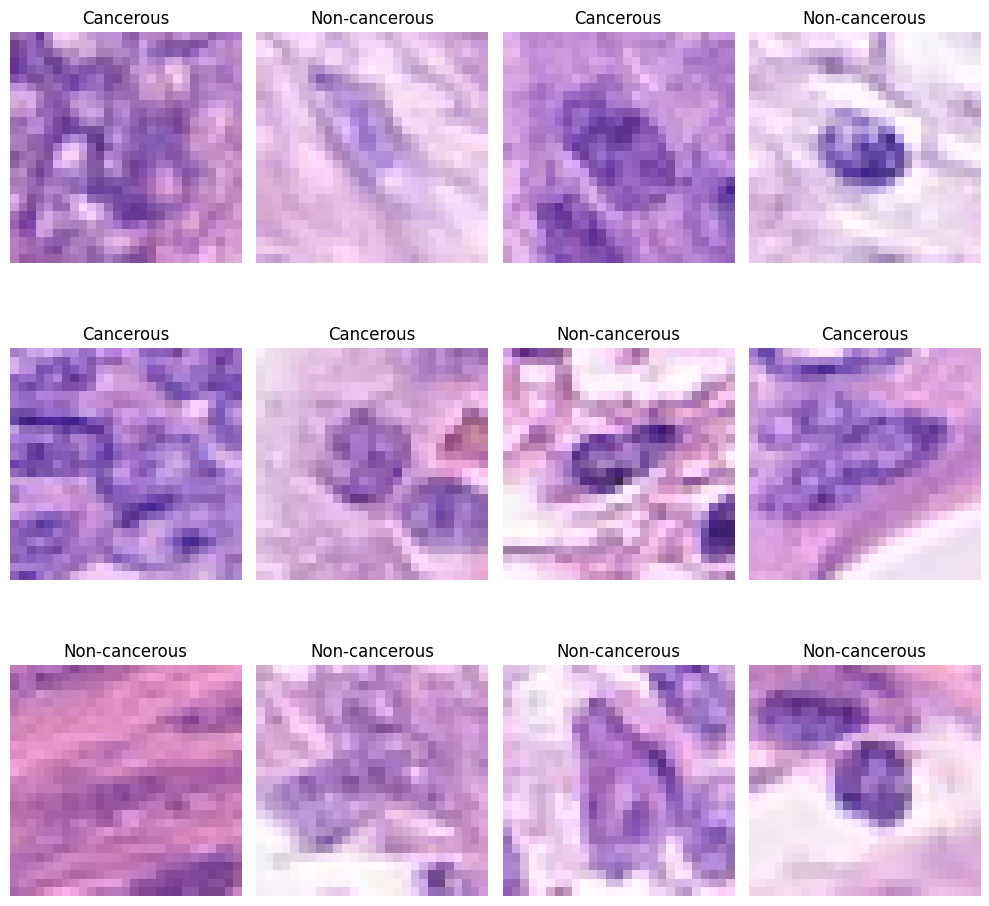

In [8]:
from PIL import Image

# defining class labels
class_labels = ['Non-cancerous', 'Cancerous']

# randomly selecting images
num_samples = 12
sample_df = data.sample(num_samples)

# plotting the images in a grid
fig, axes = plt.subplots(3, 4,  figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    image_path = sample_df.iloc[i]['ImageName']
    label = sample_df.iloc[i]['isCancerous']

    # loading and displaying the images
    image = Image.open('./patch_images/' + image_path)
    ax.axis('off')
    ax.set_title(class_labels[label])
    ax.imshow(image)

plt.tight_layout()
plt.show()

Observations:
- the cells are of different sizes and shapes
- the cells also seem to be in different orientations
- some images are brighter than others

Misclassifying the type of cell will be a very costly mistake in terms of the patients health and allocation of medical resources so when choosing a metric we need to choose one like recall which makes sure to minimize false negatives. If we optimize for recall, this might result in an increase in false positives which means that we are now dealing with the same problem. So to minimize false positives and ensure a balance we will also use precision as the other performance metric.

The two performance metrics we will focus on are:
- recall
- precision

### Data Pre Processing

Lets start by changing the data types of the ImageName and cellTypeName columns to string:

In [9]:
data['ImageName'] = data['ImageName'].astype('string')
data['cellTypeName'] = data['cellTypeName'].astype('string')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   string
 3   cellTypeName  9896 non-null   string
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), string(2)
memory usage: 464.0 KB


Lets address the differences in cell sizes, orientations, and the brightness of the images.\
For the cell sizes we will randomly zoom in on all the images in a range between 0 to 0.08 (8%)\
For the cell orientations we will randomly rotate the images in a range of -15 to 15\
For the brightness we will randomly apply a brightness between 80% - 120%\
This should help standardize all the images of the cells and create some sort of consistency between them all

In [10]:
# We have to convert 'isCancerous' to string type for the flow_from_dataframe function to work properly
data['isCancerous'] = data['isCancerous'].astype('string')

datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

augmented_data = datagen.flow_from_dataframe(
    dataframe=data,
    directory='./patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27), # image size
    class_mode='binary', # binary classification for cancerous and non-cancerous
    batch_size=batch_size, # batch size (amount of data to be processed at once)
    brightness_range =[0.8, 1.2], # applying random brightness range for augmentation
    rotation_range =15, # applying random rotation for augmentation
    zoom_range = 0.08, # applying random zoom for augmentation
    fill_mode='nearest', # filling in missing pixels after rotation/zoom
    shuffle=True, # shuffling the data for randomness in batch order 
)

Found 9896 validated image filenames belonging to 2 classes.


Lets split the data and get it ready for training the model

In [11]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True)
train_data, val_data = train_test_split(train_data, test_size=0.25, shuffle=True)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


Lets check if the class distibution of the 'isCancerous' variable in the training, validation, and test data sets is similar to the class distribution of the overall data

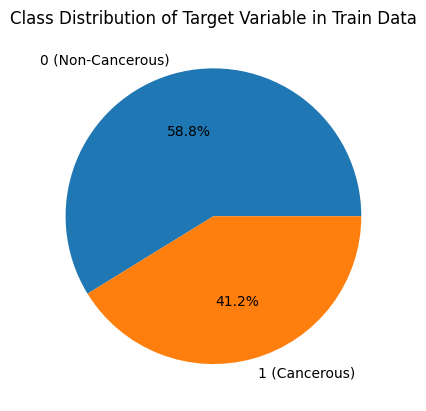

0 (Non-Cancerous): 3519
1 (Cancerous): 2418


In [12]:
train_data['isCancerous'] = train_data['isCancerous'].astype(int)
plt.title('Class Distribution of Target Variable in Train Data')

train_data_class_count = train_data['isCancerous'].value_counts()

# number of samples in each class
train_data_class_counts = [class_count[0], class_count[1]]

# create the pie chart
plt.pie(train_data_class_counts, labels=['0 (Non-Cancerous)', '1 (Cancerous)'], autopct='%1.1f%%')
plt.show()
print("0 (Non-Cancerous):", train_data_class_count[0])
print("1 (Cancerous):", train_data_class_count[1])

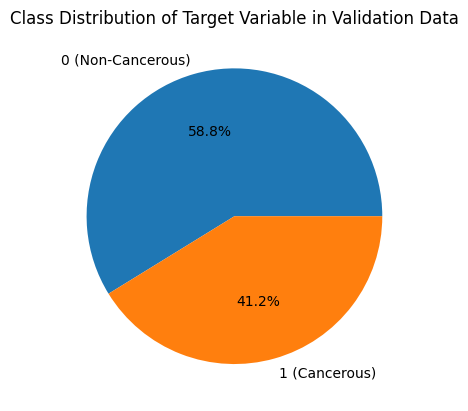

0 (Non-Cancerous): 1160
1 (Cancerous): 819


In [13]:
val_data['isCancerous'] = val_data['isCancerous'].astype(int)
plt.title('Class Distribution of Target Variable in Validation Data')

val_data_class_count = val_data['isCancerous'].value_counts()

# number of samples in each class
val_data_class_counts = [class_count[0], class_count[1]]

# create the pie chart
plt.pie(val_data_class_counts, labels=['0 (Non-Cancerous)', '1 (Cancerous)'], autopct='%1.1f%%')
plt.show()
print("0 (Non-Cancerous):", val_data_class_count[0])
print("1 (Cancerous):", val_data_class_count[1])

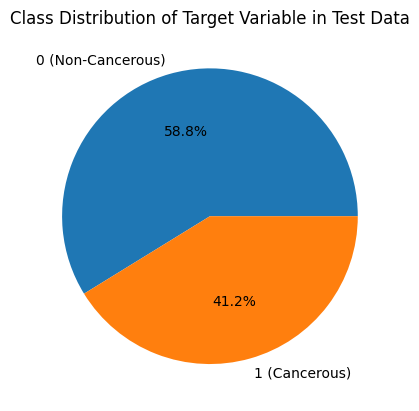

0 (Non-Cancerous): 1138
1 (Cancerous): 842


In [14]:
test_data['isCancerous'] = test_data['isCancerous'].astype(int)
plt.title('Class Distribution of Target Variable in Test Data')

test_data_class_count = test_data['isCancerous'].value_counts()

# number of samples in each class
test_data_class_counts = [class_count[0], class_count[1]]

# create the pie chart
plt.pie(test_data_class_counts, labels=['0 (Non-Cancerous)', '1 (Cancerous)'], autopct='%1.1f%%')
plt.show()
print("0 (Non-Cancerous):", test_data_class_count[0])
print("1 (Cancerous):", test_data_class_count[1])

Observations:
- the distribution of the samples in the training, validation, and test data sets are all identical to the distribution of the data before the split

In the exploratory data analysis we observed a slight imbalance in the classes of the target variable 'isCancerous'. This could cause the model to be overfitted but since it is just a slight imbalance and the distribution of the classes of the target variable in our training, validation, and testing datasets are identical to the distribution of the classes in the target variable in the data before the split, we will not perform any adjustments to it as of right now. We will leave it and investigate once we build the model if this slight imbalance has an effect.

For this project, a custom fit traditional neural network (NN) was chosen for its abilities to easily classify images without using vast amounts of processing power. It was chosen over a convolutional neural network (CNN) for this very reason.

In [15]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1

AUTOTUNE = tf.data.experimental.AUTOTUNE

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,385 (2.14 MB)

 Trainable params: 560,385 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['Precision', 'Recall']
)

In [17]:
def plot_learning_curve(train_loss, val_loss, train_metric_1, val_metric_1, train_metric_2, val_metric_2, metric_name_1, metric_name_2):
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,3,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,3,2)
    plt.plot(train_metric_1, 'r--')
    plt.plot(val_metric_1, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name_1)
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,3,3)
    plt.plot(train_metric_2, 'r--')
    plt.plot(val_metric_2, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name_2)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [18]:
train_data['isCancerous'] = train_data['isCancerous'].astype('string')
val_data['isCancerous'] = val_data['isCancerous'].astype('string')
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='./patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True
)

history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


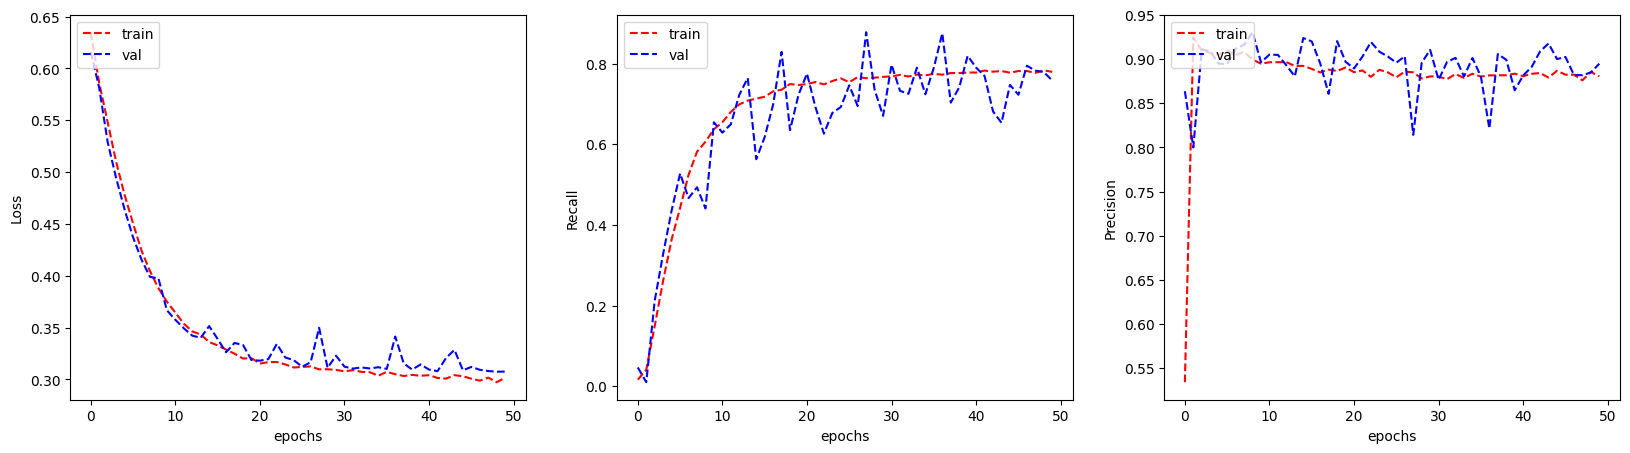

In [19]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['Recall'], history.history['val_Recall'],  
                    history.history['Precision'], history.history['val_Precision'],
                    metric_name_1='Recall', 
                    metric_name_2='Precision')

In [20]:
test_data['isCancerous'] = test_data['isCancerous'].astype('string')
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='./patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True
)
model.evaluate(test_generator)

Found 1980 validated image filenames belonging to 2 classes.
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - Precision: 0.8521 - Recall: 0.7899 - loss: 0.3380


[0.32030045986175537, 0.8625162243843079, 0.7897862195968628]

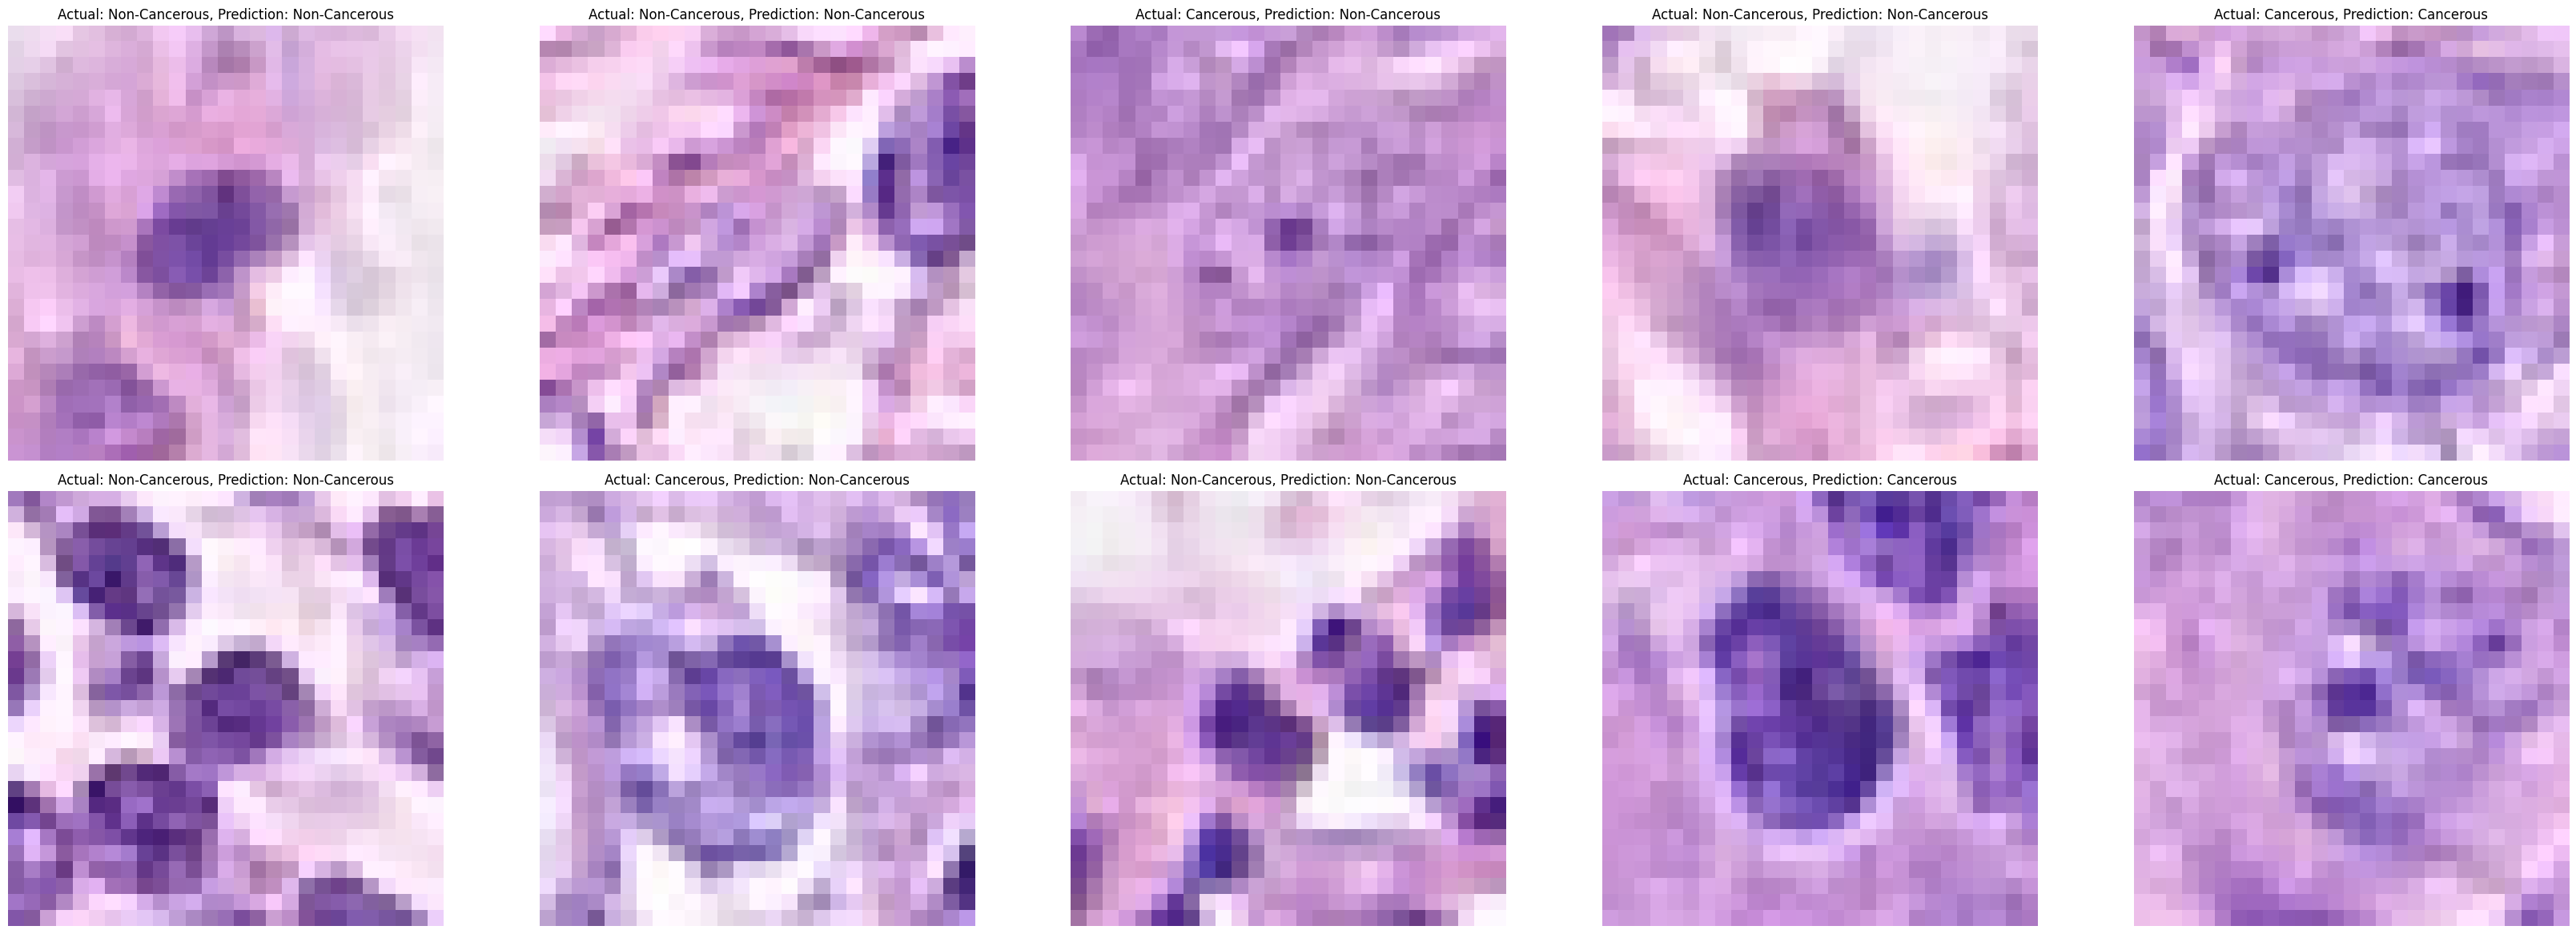

In [43]:
label_names = {'Non-Cancerous' : 0, 'Cancerous' : 1}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(35,12))
batches = 0
num_images_to_display = 10
rows = 2
cols = (num_images_to_display + rows - 1) // rows

for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches <= num_images_to_display:
            row_index = (batches - 1) // cols
            col_index = (batches - 1) % cols + 1
            plt.subplot(rows,cols,batches)
            plt.imshow(x[0])

            actual_class = d_inv[int(y[0])]  # Directly use the binary label
            predicted_probability = y_hat[0][0] # Get the probability of the cell being cancerous
            predicted_class = d_inv[1] if predicted_probability >= 0.5 else d_inv[0]

            plt.title(f"Actual: {actual_class}, Prediction: {predicted_class}")
            
        else:
            break
        plt.tight_layout()
        plt.axis('off')